# CAPEC co-occurrence matrix using phrases
Ivan Ulloa, 2-14-2021

In [1]:
import xml.etree.ElementTree as ET
import xmltodict
import json
import os
import pandas as pd
import spacy
import numpy as np
import nltk
from nltk import bigrams
import itertools
import seaborn as sns

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_lg")
import pprint
pp = pprint.PrettyPrinter(indent=4)

##  Load CAPEC dataset and save to JSON

In [2]:
tree = ET.parse('data/1000.xml')
xml_data = tree.getroot()
# Change the encoding type to be able to set it to the one you need
xmlstr = ET.tostring(xml_data, encoding='utf-8', method='xml')

In [3]:
capec = xmltodict.parse(xmlstr)
with open('data/capec_data.json', 'w') as f:
    f.write(json.dumps(capec))
f.close()

In [4]:
#data_dict = dict(xmltodict.parse(xmlstr))

## Extract ID, Descriptions, CAPEC relationships, and CWE Relation

In [5]:
ID = []
Desc = []
Rel_CAPEC = []
Rel_CWE = []
for i in range(len(capec['ns0:Attack_Pattern_Catalog']['ns0:Attack_Patterns']['ns0:Attack_Pattern'])):
    ID.append(capec['ns0:Attack_Pattern_Catalog']['ns0:Attack_Patterns']['ns0:Attack_Pattern'][i]['@ID'])
    Desc.append(capec['ns0:Attack_Pattern_Catalog']['ns0:Attack_Patterns']['ns0:Attack_Pattern'][i]['ns0:Description'])
    try:
        Rel_CAPEC.append(capec['ns0:Attack_Pattern_Catalog']['ns0:Attack_Patterns']['ns0:Attack_Pattern'][i]['ns0:Related_Attack_Patterns']['ns0:Related_Attack_Pattern'])
    except:
        Rel_CAPEC.append('None')
    try:
        Rel_CWE.append(capec['ns0:Attack_Pattern_Catalog']['ns0:Attack_Patterns']['ns0:Attack_Pattern'][i]['ns0:Related_Weaknesses']['ns0:Related_Weakness'])
    except:
        Rel_CWE.append('None')
dict = {'ID': ID, 'Description': Desc, 'rel_CAPEC':Rel_CAPEC, 'rel_CWE':Rel_CWE}

In [6]:
CAPEC_df = pd.DataFrame(dict)
CAPEC_df

,ID,Description,rel_CAPEC,rel_CWE
0,1,"In applications, particularly web applications...","[{'@CAPEC_ID': '122', '@Nature': 'ChildOf'}, {...","[{'@CWE_ID': '276'}, {'@CWE_ID': '285'}, {'@CW..."
1,10,This attack pattern involves causing a buffer ...,"{'@CAPEC_ID': '100', '@Nature': 'ChildOf'}","[{'@CWE_ID': '120'}, {'@CWE_ID': '302'}, {'@CW..."
2,100,Buffer Overflow attacks target improper or mis...,"{'@CAPEC_ID': '123', '@Nature': 'ChildOf'}","[{'@CWE_ID': '120'}, {'@CWE_ID': '119'}, {'@CW..."
3,101,An attacker can use Server Side Include (SSI) ...,"{'@CAPEC_ID': '253', '@Nature': 'ChildOf'}","[{'@CWE_ID': '97'}, {'@CWE_ID': '74'}, {'@CWE_..."
4,102,Session sidejacking takes advantage of an unen...,"{'@CAPEC_ID': '593', '@Nature': 'ChildOf'}","[{'@CWE_ID': '294'}, {'@CWE_ID': '522'}, {'@CW..."
...,...,...,...,...
522,94,This type of attack targets the communication ...,None,"[{'@CWE_ID': '300'}, {'@CWE_ID': '290'}, {'@CW..."
523,95,This attack targets the WSDL interface made av...,"{'@CAPEC_ID': '54', '@Nature': 'ChildOf'}",{'@CWE_ID': '538'}
524,96,An application typically makes calls to functi...,"{'@CAPEC_ID': '603', '@Nature': 'ChildOf', 'ns...","[{'@CWE_ID': '589'}, {'@CWE_ID': '227'}]"
525,97,Cryptanalysis is a process of finding weakness...,"[{'@CAPEC_ID': '192', '@Nature': 'ChildOf'}, {...","[{'@CWE_ID': '327'}, {'@CWE_ID': '1240'}, {'@C..."


In [7]:
# Create corpus from CAPEC descriptions
corpus = ''

for desc in Desc:
    try:
        corpus += desc +'\n'
    except:
        if desc:
            corpus += desc['html:p'][0] +'\n'

In [8]:
#doc = nlp(corpus)

In [9]:
with open("data/CAPEC_corpus.txt", "w") as text_file:
    text_file.write(corpus)

# Co-occurrence Matrix using Autophrase extracted phrases

## Load Autphrase results
The Autophraser is executed separately using the CAPEC_corpus.txt file renamed to DBLP.txt

In [10]:
with open('data/AutoPhrase_multi-words.txt') as f:
    lines = [line.rstrip() for line in f]

In [11]:
float(lines[0].split('\t')[0])

0.9731306755

In [12]:
threshold = 0.5
phrases_list = []
for line in lines:
    score = float(line.split('\t')[0])
    if score >= threshold:
        phrases_list.append(line.split('\t')[1])

In [13]:
# Print example phrases
phrases_list[0:10]

['sql injection',
 'ip address',
 'cross site scripting',
 'social engineering',
 'web browser',
 'buffer overflow',
 'web server',
 'operating systems',
 'supply chain',
 'sequence number']

## Get descriptions, tokenize, make lower-case, and remove punctuation

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  

In [15]:
#stop_words = set(stopwords.words('english'))  

word_tokens = word_tokenize(corpus.lower())
  
#filtered_corpus = [w for w in word_tokens if not w in stop_words]  
  
filtered_corpus = []  
  
for w in word_tokens:  
#    if w not in stop_words and w.isalpha():  
     if w.isalpha():
        filtered_corpus.append(w)  

## Iterate and find Autophrase phrases in the corpus that match exactly
This function returns the start and end index of the corpus list of words where the phrase matches

In [16]:
def find_all_matches(split_phrase, filered_corpus):
    # Find index of all matches of first word in the phrase
    num_words = len(split_phrase)
    indices = [i for i, x in enumerate(filtered_corpus) if x == split_phrase[0]]
    results = []
    # Iterate over all first word match indices
    for index_num in indices:
        # Iterate over all words in phrase
        all_sum = 0
        for i in range(num_words):
            try: 
                if split_phrase[i]==filtered_corpus[index_num+i]:
                    all_sum += 1
                else:
                    break
            except:
                pass
        if all_sum == num_words:
            results.append((index_num, index_num + num_words - 1))
    return results

This function checks if any phrase exists in the N words surrounding the first phrase found

In [17]:
def check_match(split_phrase, words, main_phrase):
    # Find index of all matches of first word in the phrase
    num_words = len(split_phrase)
    indices = [i for i, x in enumerate(words) if x == split_phrase[0]]
    results = []
    # Iterate over all first word match indices
    for index_num in indices:
        # Iterate over all words in phrase
        all_sum = 0
        for i in range(num_words):
            try: 
                if split_phrase[i]==words[index_num+i]:
                    all_sum += 1
                else:
                    break
            except:
                pass
        if all_sum == num_words:
            return((' '.join(split_phrase), main_phrase))
    return 0

## Check if any phrase exists in the N previous and N after words (N=5)

In [18]:
N = 5
matches_list = []
for main_phrase in phrases_list:
    index_pairs = find_all_matches(main_phrase.split(' '),filtered_corpus)
    for index_pair in index_pairs:
        words_prev = filtered_corpus[index_pair[0] - N : index_pair[0]]
        words_after = filtered_corpus[index_pair[1] + 1 : index_pair[1] + N + 1]
        for phrase in phrases_list:
            # Check before
            pair_prev = check_match(phrase.split(' '),words_prev, main_phrase)
            pair_after = check_match(phrase.split(' '),words_after, main_phrase)
            if pair_prev != 0:
                matches_list.append(pair_prev)
            if pair_after != 0:
                matches_list.append(pair_after)

In [19]:
print('Example phrase matches')
matches_list[0:10]

Example phrase matches


[('service provider', 'sql injection'),
 ('service provider', 'sql injection'),
 ('error messages', 'sql injection'),
 ('sql injection', 'sql injection'),
 ('sql injection', 'sql injection'),
 ('error messages', 'sql injection'),
 ('ip address', 'ip address'),
 ('ip address', 'ip address'),
 ('arbitrary code', 'cross site scripting'),
 ('third party', 'web server')]

## Make co-occurrence matrix

In [20]:
def generate_co_occurrence_matrix(phrases_list,matches_list):
    vocab = set(phrases_list) 
    vocab = list(vocab)
    vocab_index = {word: i for i, word in enumerate(vocab)}

    # Create bigrams from all words in corpus
    bi_grams = matches_list
    # Frequency distribution of bigrams ((word1, word2), num_occurrences)
    bigram_freq = nltk.FreqDist(bi_grams).most_common(len(bi_grams))

    # Initialize co-occurrence matrix
    # co_occurrence_matrix[current][previous]
    co_occurrence_matrix = np.zeros((len(vocab), len(vocab)))

    # Loop through the bigrams taking the current and previous word,
    # and the number of occurrences of the bigram.
    for bigram in bigram_freq:
        current = bigram[0][1]
        previous = bigram[0][0]
        count = bigram[1]
        pos_current = vocab_index[current]
        pos_previous = vocab_index[previous]
        co_occurrence_matrix[pos_current][pos_previous] = count
    co_occurrence_matrix = np.matrix(co_occurrence_matrix)
    # return the matrix and the index
    return co_occurrence_matrix, vocab_index

In [21]:
matrix, vocab_index = generate_co_occurrence_matrix(phrases_list,matches_list)

In [22]:
data_matrix = pd.DataFrame(matrix, index=vocab_index,
                             columns=vocab_index)

## Sort by the sum of the all columns

In [23]:
#Sort rows of data_matrix by the sum of the columns of each row in descending order
data_matrix['sum_column'] = data_matrix.sum(axis=1)
data_matrix = data_matrix.sort_values(by='sum_column', ascending=False)
data_matrix = data_matrix.drop(columns=['sum_column'])

## Sort by the sum of all rows

In [24]:
data_matrix.loc['sum_row'] = data_matrix.sum(axis=1)
data_matrix = data_matrix.sort_values(by = 'sum_row',ascending=False, axis=1)
data_matrix = data_matrix.drop(index='sum_row')

In [25]:
data_matrix

,service provider,sql injection,sensitive information,web server,operating system,web application,error messages,os fingerprinting,error message,malicious script,...,web browser,closed ports,brute force,an open port,rfc 793,client side,input validation,takes advantage of,access control,http request
service provider,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sql injection,2.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sensitive information,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
web server,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
operating system,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
web application,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
error messages,0.0,2.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
os fingerprinting,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
error message,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
malicious script,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Display Co-occurrence matrix

In [28]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 500

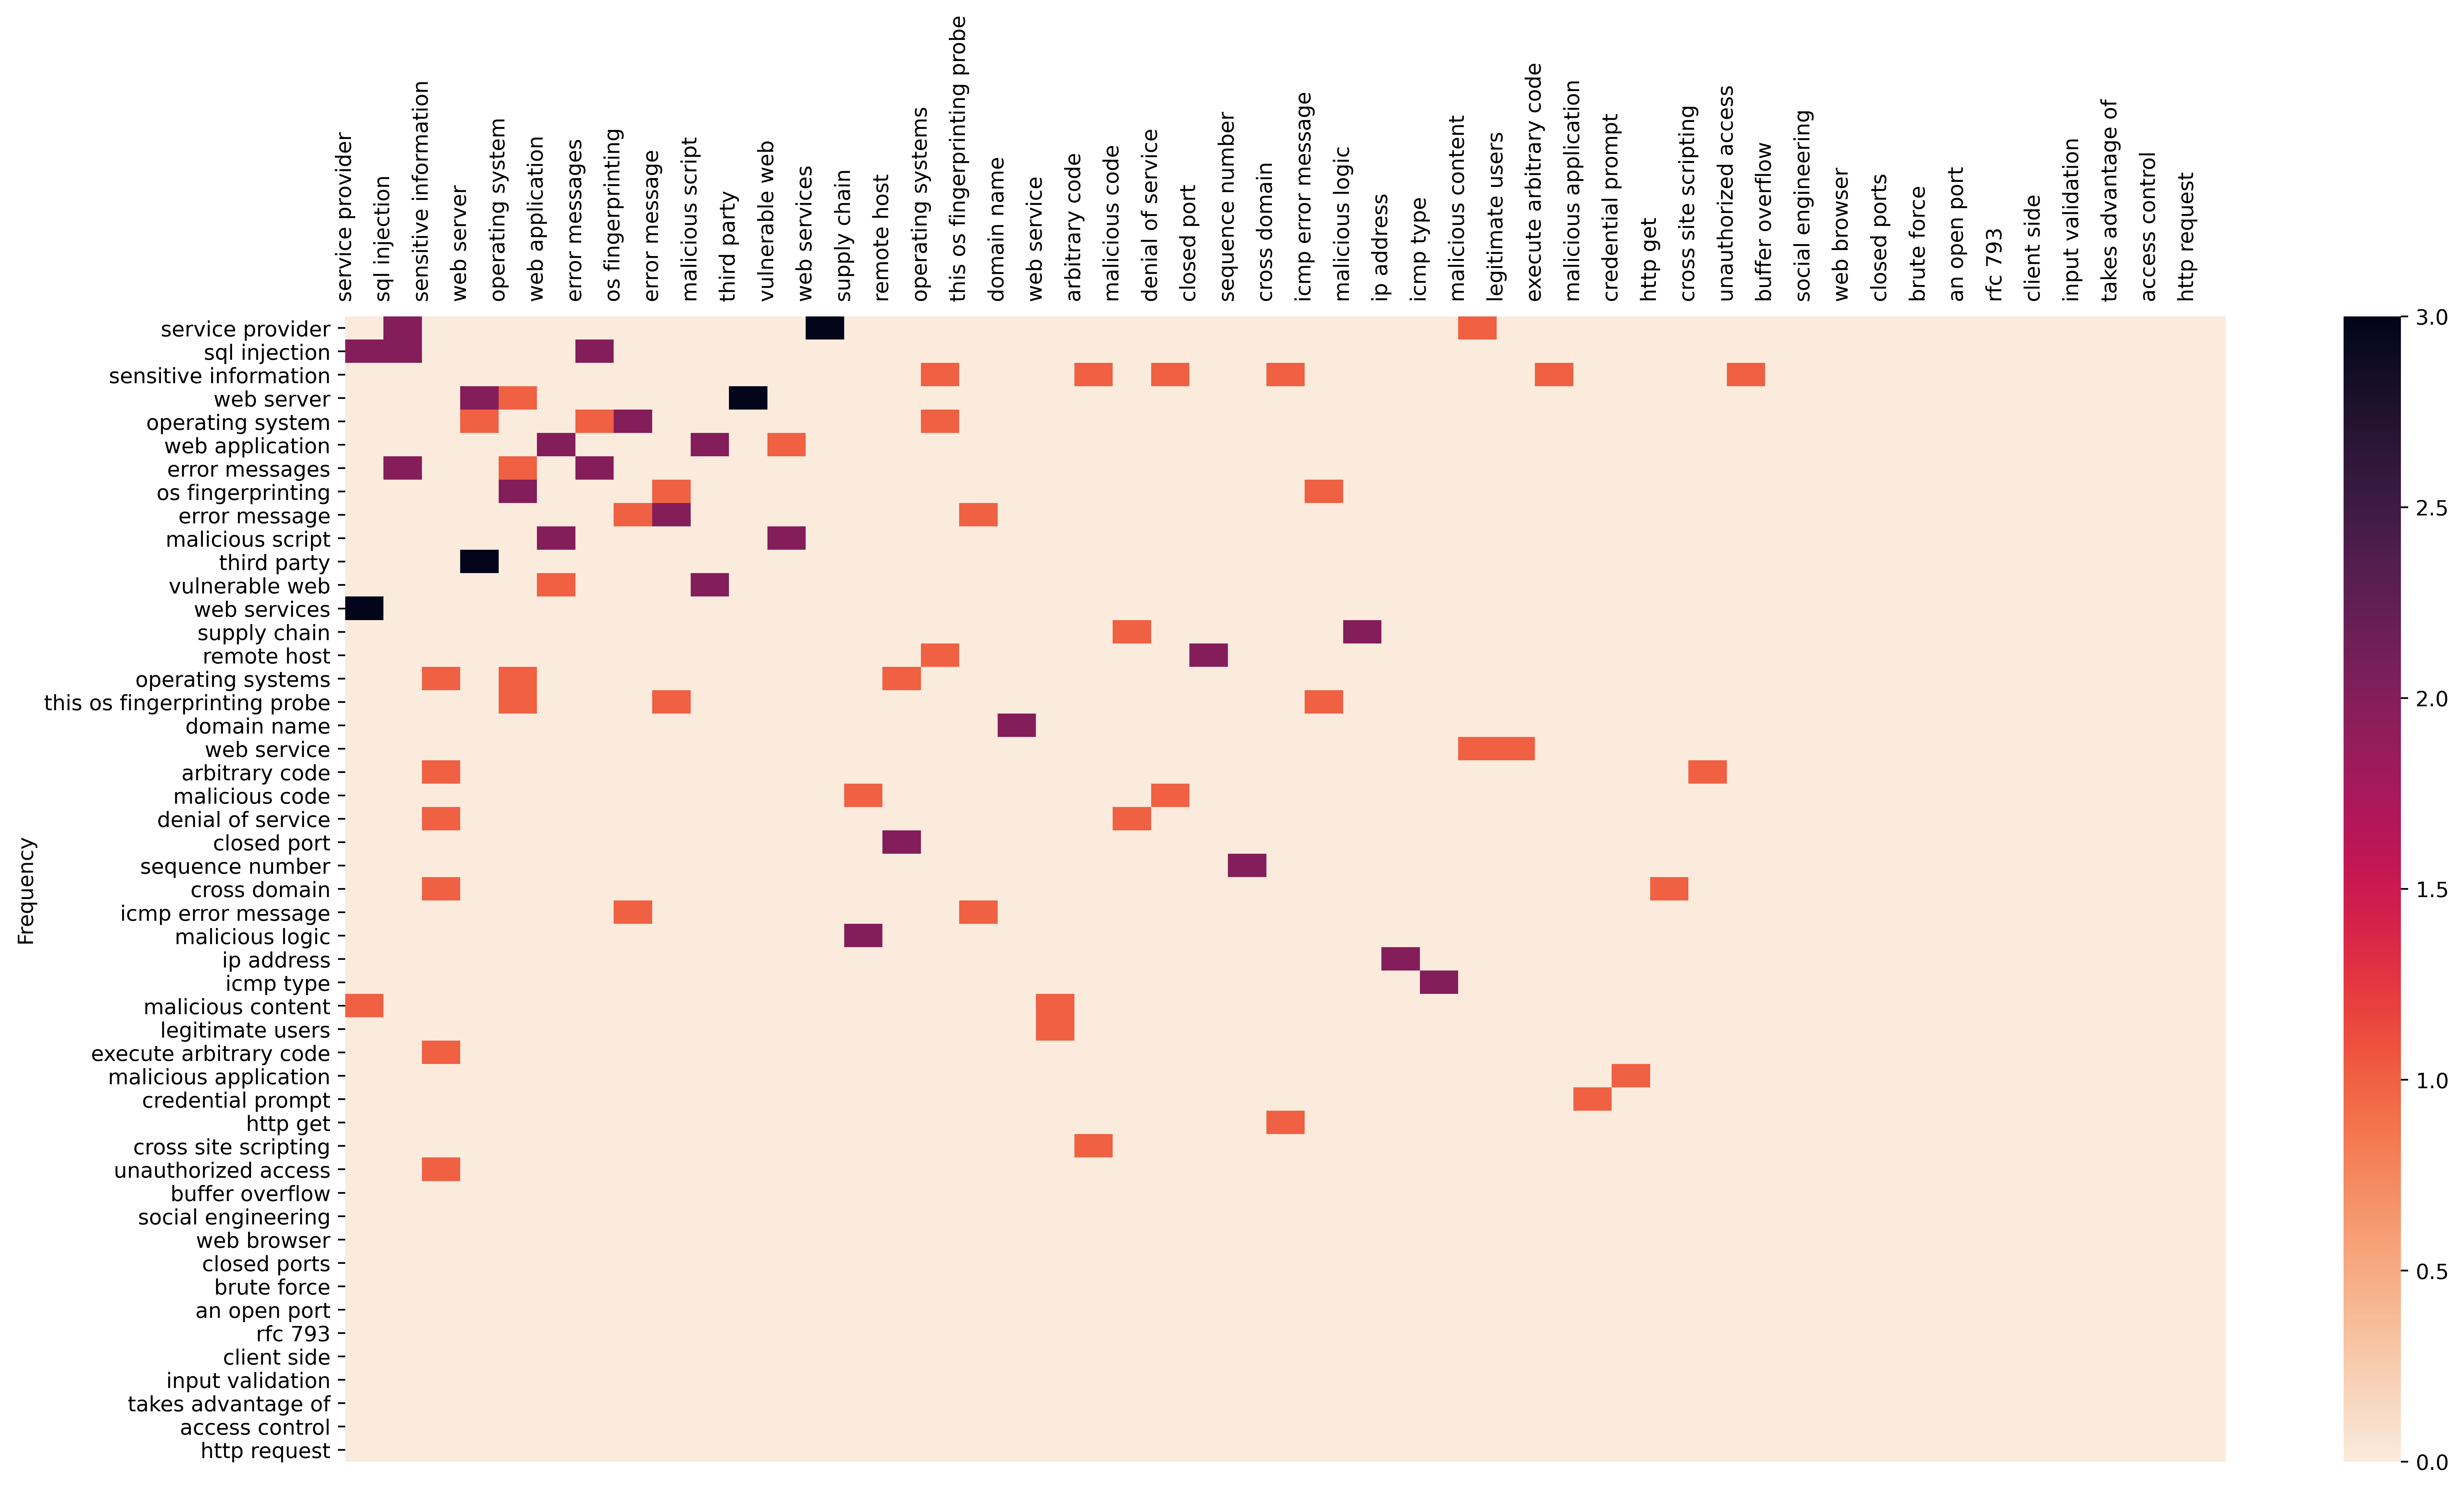

In [37]:
df = data_matrix.iloc[0:100,0:100]
plt.figure(figsize=(20,10))
ax = sns.heatmap(df, annot=False, cmap="rocket_r")
#plt.figure(figsize=(25,25))
#plt.imshow(df)
#plt.colorbar()
plt.xticks(range(len(df)),df.columns, rotation=90)
#plt.yticks(range(len(df)),df.index)
plt.ylabel('Frequency')
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.savefig('CAPEC_matrix.jpg')
plt.show()

## Save Sorted Data Matrix to CSV

In [ ]:
data_matrix.to_csv('data/CAPEC_coocurrence_matrix.csv')